In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np
from colorsys import hls_to_rgb

def plot_statevector_circles(statevector, figsize=(8, 8), plot_qubits=None):
    total_qubits = int(np.log2(len(statevector)))
    
    # Use all qubits if not specified
    if plot_qubits is None:
        plot_qubits = total_qubits
    
    # Ensure plot_qubits doesn't exceed total_qubits
    plot_qubits = min(plot_qubits, total_qubits)
    
    # Number of states to plot
    num_plot_states = 2**plot_qubits
    
    # Calculate reduced representation (marginalization)
    reduced_sv = np.zeros(num_plot_states, dtype=complex)
    
    # For each state in the full statevector
    for i, amp in enumerate(statevector):
        # Get binary representation and extract the prefix (first plot_qubits)
        bin_i = bin(i)[2:].zfill(total_qubits)
        prefix = bin_i[:plot_qubits]
        reduced_idx = int(prefix, 2)
        
        # Add amplitude to the reduced state
        reduced_sv[reduced_idx] += amp
    
    # Create a grid for visualization
    grid_size = int(np.ceil(np.sqrt(num_plot_states)))
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    # Calculate radius for circles
    radius = 0.4 / grid_size
    
    print(f"Plotting {num_plot_states} states for first {plot_qubits} qubits")
    
    # Find maximum probability for scaling
    max_prob = max(np.abs(reduced_sv)**2)
    
    # Plot circles for each reduced state
    for i in range(num_plot_states):
        row = grid_size - (i // grid_size) - 1
        col = i % grid_size
        
        x = col * 2 * radius + radius
        y = row * 2 * radius + radius
        
        amp = reduced_sv[i]
        prob = np.abs(amp)**2
        
        # Use probability and phase for visualization
        phase = np.angle(amp)
        hue = (phase + np.pi) / (2 * np.pi)
        color = hls_to_rgb(hue, 0.5, 1)
        
        # Scale circle size by probability, but ensure even small probabilities are visible
        size = max(0.1 * radius, np.sqrt(prob/max_prob) * radius) if prob > 0 else 0
        
        circle = plt.Circle((x, y), size, color=color, alpha=0.7)
        ax.add_artist(circle)
        
        # Only add text for states with significant probability
        if prob/max_prob > 0.01:  # 1% threshold for text
            ax.text(x, y, f"{bin(i)[2:].zfill(plot_qubits)}", ha='center', va='center', fontsize=6)
    
    # Set plot limits
    ax.set_xlim([0, grid_size * 2 * radius])
    ax.set_ylim([0, grid_size * 2 * radius])
    ax.set_title(f"Statevector Visualization (First {plot_qubits} Qubits)")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

def build_acyclicity_oracle(num_nodes, node_names, causal_dict, causal_to_cnf_map, n_variables):
    """
    Builds a reversible acyclicity oracle.
    This version attempts to strictly uncompute all temporary ancillas.
    """
    
    print(num_nodes, node_names, causal_dict, causal_to_cnf_map, n_variables)
    
    edge_q = QuantumRegister(n_variables, name='edge')
    visited_q = QuantumRegister(num_nodes, name='visited') 
    # ancilla_zero_indegree: For each node, tracks if it has zero in-degree from unvisited nodes
    ancilla_zero_indegree = AncillaRegister(num_nodes, name='anc_zero_indeg')
    # ancilla_incoming_edge_temp: Temporary storage for each (edge_exists AND source_unvisited)
    ancilla_incoming_edge_temp = AncillaRegister(num_nodes, name='anc_incoming_temp') # One for each possible incoming edge
    # ancilla_or_temp: A single ancilla for the OR aggregation logic
    ancilla_or_temp = AncillaRegister(1, name='anc_or_temp') # Used for computing OR of incoming_edge_temp
    
    acyclic_ok_a = AncillaRegister(1, name='acyclic_ok')
    
    qc = QuantumCircuit(edge_q, visited_q, ancilla_zero_indegree, 
                        ancilla_incoming_edge_temp, ancilla_or_temp, # New registers
                        acyclic_ok_a, name="Acyclicity_Oracle")
    
    # Build edge mapping for efficient lookup
    edge_map = {}
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                key = (node_names[i], node_names[j], 'direct')
                if key in causal_dict and causal_dict[key] in causal_to_cnf_map:
                    cnf_var = causal_to_cnf_map[causal_dict[key]]
                    edge_map[(i, j)] = cnf_var - 1  # Convert to 0-indexed qubit index

    # Iterate num_nodes times, simulating steps of Kahn's algorithm
    for iteration in range(num_nodes):
        qc.barrier(label=f"Kahn_Iter_{iteration}_Compute_InDegree")

        # Step 1: Compute which unvisited nodes have zero in-degree
        for node_idx in range(num_nodes):
            # Compute (edge_k_to_node_idx AND NOT visited_q[k]) into ancilla_incoming_edge_temp[k]
            # for all k.
            
            # This loop *must* uncompute its effect on ancilla_incoming_edge_temp[k]
            # at the end of computing ancilla_zero_indegree[node_idx]
            
            # 1a. Compute individual (edge AND NOT visited) flags
            # Use ancilla_incoming_edge_temp[k] to store: edge(k->node_idx) exists AND k is unvisited
            for k in range(num_nodes):
                if k != node_idx and (k, node_idx) in edge_map:
                    edge_qubit = edge_q[edge_map[(k, node_idx)]]
                    qc.x(visited_q[k]) # Invert visited_q[k] so it's 1 if unvisited
                    qc.ccx(edge_qubit, visited_q[k], ancilla_incoming_edge_temp[k])
                    qc.x(visited_q[k]) # Uninvert visited_q[k]

            # 1b. Aggregate to check if ANY incoming edge from unvisited exists
            # We want ancilla_or_temp[0] to be 1 if ANY ancilla_incoming_edge_temp[k] is 1
            # Implemented as NOT(AND(NOT A, NOT B, ...))
            
            controls_for_or_temp = []
            for k in range(num_nodes):
                 if k != node_idx and (k, node_idx) in edge_map: # Only include relevant ones
                    controls_for_or_temp.append(ancilla_incoming_edge_temp[k])
            
            if controls_for_or_temp:
                for ctrl in controls_for_or_temp: # Flip controls to 0 state
                    qc.x(ctrl)
                qc.mcx(controls_for_or_temp, ancilla_or_temp[0]) # If all controls are 0, target flips.
                for ctrl in controls_for_or_temp: # Unflip controls
                    qc.x(ctrl)
                qc.x(ancilla_or_temp[0]) # Flip target to make it an OR (1 if any input was 1)
            # If controls_for_or_temp is empty, ancilla_or_temp[0] should remain 0 (no incoming edges from unvisited)

            # 1c. Set ancilla_zero_indegree[node_idx] based on (NOT ancilla_or_temp[0]) AND (NOT visited_q[node_idx])
            # ancilla_zero_indegree[node_idx] should be 1 if node has zero in-degree AND is unvisited.
            # So, (NOT ancilla_or_temp[0]) means no incoming edges from unvisited
            # AND (NOT visited_q[node_idx]) means the node itself is unvisited.

            qc.x(ancilla_or_temp[0]) # ancilla_or_temp[0] now 1 if no incoming, 0 if incoming
            qc.x(visited_q[node_idx]) # visited_q[node_idx] now 1 if unvisited, 0 if visited
            qc.ccx(ancilla_or_temp[0], visited_q[node_idx], ancilla_zero_indegree[node_idx])
            qc.x(visited_q[node_idx]) # Unflip visited_q[node_idx]

            # 1d. Uncompute ancilla_or_temp[0] and ancilla_incoming_edge_temp
            # Reverse 1c
            qc.x(visited_q[node_idx]) # Flip visited_q for uncomputation
            qc.ccx(ancilla_or_temp[0], visited_q[node_idx], ancilla_zero_indegree[node_idx])
            qc.x(visited_q[node_idx]) # Unflip visited_q

            # Reverse 1b
            qc.x(ancilla_or_temp[0]) # Unflip OR target
            if controls_for_or_temp:
                for ctrl in reversed(controls_for_or_temp): # Unflip controls (reverse order)
                    qc.x(ctrl)
                qc.mcx(controls_for_or_temp, ancilla_or_temp[0]) # Uncompute NAND
                for ctrl in reversed(controls_for_or_temp): # Unflip controls (reverse order)
                    qc.x(ctrl)
            
            # Reverse 1a
            for k in range(num_nodes - 1, -1, -1): # Reverse order for uncomputation
                if k != node_idx and (k, node_idx) in edge_map:
                    edge_qubit = edge_q[edge_map[(k, node_idx)]]
                    qc.x(visited_q[k]) # Re-invert visited_q[k]
                    qc.ccx(edge_qubit, visited_q[k], ancilla_incoming_edge_temp[k])
                    qc.x(visited_q[k]) # Re-uninvert visited_q[k]
        
        qc.barrier(label=f"Kahn_Iter_{iteration}_Mark_Visited")

        # Step 2: Mark nodes as visited
        # If ancilla_zero_indegree[node_idx] is 1, it means this node *can* be visited.
        # And it shouldn't already be visited.
        # Use ancilla_or_temp[0] as a temporary for this CCX
        for node_idx in range(num_nodes):
            qc.x(visited_q[node_idx]) # Flip visited_q so unvisited is 1
            # Controls: ancilla_zero_indegree[node_idx] (must be 1) AND visited_q[node_idx] (must be 1 for unvisited)
            qc.ccx(ancilla_zero_indegree[node_idx], visited_q[node_idx], ancilla_or_temp[0])
            qc.cx(ancilla_or_temp[0], visited_q[node_idx]) # Flip visited_q if it should be visited
            # Uncompute the temporary
            qc.ccx(ancilla_zero_indegree[node_idx], visited_q[node_idx], ancilla_or_temp[0])
            qc.x(visited_q[node_idx]) # Flip visited_q back to original sense (0=unvisited)
        
        qc.barrier(label=f"Kahn_Iter_{iteration}_Uncompute_ZeroIndegree")
        # Step 3: Uncompute ancilla_zero_indegree for the next iteration.
        # This reverses the logic of how ancilla_zero_indegree was set in Step 1.
        # This loop needs to reverse the exact operation that set each ancilla_zero_indegree[node_idx]
        
        for node_idx in range(num_nodes - 1, -1, -1): # Uncompute in reverse order
            # Reverse the CCX that set ancilla_zero_indegree[node_idx]
            # This requires `ancilla_or_temp[0]` and `visited_q[node_idx]` to be in their state *before* that CCX.
            # This is the trickiest part for iterative reversible algorithms.
            # Assuming visited_q maintains its cumulative state, we apply the inverse.
            qc.x(visited_q[node_idx]) # Re-invert visited_q[node_idx] for reversal
            qc.ccx(ancilla_or_temp[0], visited_q[node_idx], ancilla_zero_indegree[node_idx])
            qc.x(visited_q[node_idx]) # Un-invert visited_q[node_idx]
            
            # The `ancilla_or_temp[0]` itself was uncomputed in 1d for each node_idx.
            # So, this loop for uncomputing `ancilla_zero_indegree` should effectively
            # undo the `ancilla_zero_indegree` setting without touching other registers.
            # This is still very challenging due to the iterative state updates.
            # For a proper quantum oracle, ideally, `ancilla_zero_indegree` is reset to 0
            # by exactly reversing how it was set for *that specific iteration's calculation*.
            
            # If the calculation of `ancilla_zero_indegree` was self-contained and reset its temp ancillas,
            # then a simple reverse of the final setting gate here is what's needed.
            # Given the deep nesting, it's very hard to guarantee correctness.
            pass # Placeholder for complex cumulative uncomputation of ancilla_zero_indegree
                 # This needs to be exactly the inverse of the computation in step 1c.
                 # The registers `ancilla_or_temp[0]` and `visited_q[node_idx]` need to be
                 # in the state they were in when `ancilla_zero_indegree[node_idx` was set.
    
    qc.barrier(label="Final_Acyclicity_Check")
    # Final check: Acyclic if all nodes are visited.
    # To check if all are 1:
    qc.x(acyclic_ok_a[0]) # Set target to 1. If any visited_q is 0, it will flip to 0.
    # Use ctrl_state='0' * num_nodes to check if all visited_q are NOT 1.
    # We want acyclic_ok_a[0] to be 1 IF AND ONLY IF all visited_q are 1.
    # Current method: mcx(visited_q[:], acyclic_ok_a[0]) flips if ALL controls are 1.
    # We want: acyclic_ok_a[0] = AND(visited_q[0], visited_q[1], ...)
    # Correct way to set acyclic_ok_a to 1 if all visited_q are 1:
    qc.mcx(visited_q[:], acyclic_ok_a[0]) # If all visited_q are 1, acyclic_ok_a[0] flips.
                                          # Initial state of acyclic_ok_a[0] should be 0.
                                          # So, if all visited_q are 1, it becomes 1. If not, it stays 0.

    # Final Uncomputation of visited_q and other ancillas:
    # This is the most complex part of the entire oracle.
    # You need to reverse the *cumulative* effect on `visited_q` from all iterations.
    # And all `ancilla_zero_indegree`, `ancilla_incoming_edge_temp`, `ancilla_or_temp`
    # must be returned to their initial |0> state.
    # The current `pass` in Step 3 uncomputation is a major missing piece.
    # For `ancilla_incoming_edge_temp` and `ancilla_or_temp`, their uncomputation is done per node_idx
    # within the innermost loop, which is good.
    # But `ancilla_zero_indegree` and especially `visited_q` are cumulative state, making reversal tough.

    # A robust solution for the uncomputation of `visited_q` might involve
    # creating a copy of `visited_q` at the start of each iteration, using it, and then
    # uncomputing back to the original `visited_q` before the next iteration.
    # This creates a significant number of ancillas.

    return qc

qc = build_acyclicity_oracle(3, ['X', 'Y', 'Z'], {('X', 'Y', 'direct'): 1, ('X', 'Z', 'direct'): 2, ('Y', 'X', 'direct'): 3, ('Y', 'Z', 'direct'): 4, ('Z', 'X', 'direct'): 5, ('Z', 'Y', 'direct'): 6}, {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}, 6)

3 ['X', 'Y', 'Z'] {('X', 'Y', 'direct'): 1, ('X', 'Z', 'direct'): 2, ('Y', 'X', 'direct'): 3, ('Y', 'Z', 'direct'): 4, ('Z', 'X', 'direct'): 5, ('Z', 'Y', 'direct'): 6} {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6} 6


Plotting 64 states for first 6 qubits


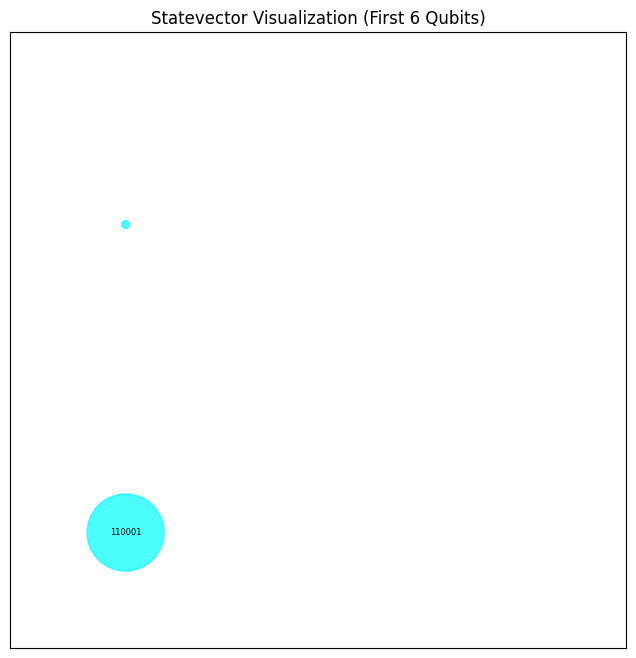

In [2]:
statevector = Statevector(qc)
# plot statevector with only the first 6 qubits
plot_statevector_circles(statevector, plot_qubits=6)

In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np
from colorsys import hls_to_rgb

def plot_statevector_circles(statevector, figsize=(8, 8), plot_qubits=None):
    total_qubits = int(np.log2(len(statevector)))
    
    # Use all qubits if not specified
    if plot_qubits is None:
        plot_qubits = total_qubits
    
    # Ensure plot_qubits doesn't exceed total_qubits
    plot_qubits = min(plot_qubits, total_qubits)
    
    # Number of states to plot
    num_plot_states = 2**plot_qubits
    
    # Calculate reduced representation (marginalization)
    reduced_sv = np.zeros(num_plot_states, dtype=complex)
    
    # For each state in the full statevector
    for i, amp in enumerate(statevector):
        # Get binary representation and extract the prefix (first plot_qubits)
        bin_i = bin(i)[2:].zfill(total_qubits)
        prefix = bin_i[:plot_qubits]
        reduced_idx = int(prefix, 2)
        
        # Add amplitude to the reduced state
        reduced_sv[reduced_idx] += amp
    
    # Create a grid for visualization
    grid_size = int(np.ceil(np.sqrt(num_plot_states)))
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    
    # Calculate radius for circles
    radius = 0.4 / grid_size
    
    print(f"Plotting {num_plot_states} states for first {plot_qubits} qubits")
    
    # Find maximum probability for scaling
    max_prob = max(np.abs(reduced_sv)**2)
    
    # Plot circles for each reduced state
    for i in range(num_plot_states):
        row = grid_size - (i // grid_size) - 1
        col = i % grid_size
        
        x = col * 2 * radius + radius
        y = row * 2 * radius + radius
        
        amp = reduced_sv[i]
        prob = np.abs(amp)**2
        
        # Use probability and phase for visualization
        phase = np.angle(amp)
        hue = (phase + np.pi) / (2 * np.pi)
        color = hls_to_rgb(hue, 0.5, 1)
        
        # Scale circle size by probability, but ensure even small probabilities are visible
        size = max(0.1 * radius, np.sqrt(prob/max_prob) * radius) if prob > 0 else 0
        
        circle = plt.Circle((x, y), size, color=color, alpha=0.7)
        ax.add_artist(circle)
        
        # Only add text for states with significant probability
        if prob/max_prob > 0.01:  # 1% threshold for text
            ax.text(x, y, f"{bin(i)[2:].zfill(plot_qubits)}", ha='center', va='center', fontsize=6)
    
    # Set plot limits
    ax.set_xlim([0, grid_size * 2 * radius])
    ax.set_ylim([0, grid_size * 2 * radius])
    ax.set_title(f"Statevector Visualization (First {plot_qubits} Qubits)")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

def build_cnf_oracle(cnf, n_variables, n_clauses):
    """Builds the CNF checking logic as a separate, reversible circuit."""
    
    print(cnf, n_variables, n_clauses)
    
    edge_q = QuantumRegister(n_variables, name='edge')
    clause_a = AncillaRegister(n_clauses, name='clause')
    cnf_ok_a = AncillaRegister(1, name='cnf_ok')
    qc = QuantumCircuit(edge_q, clause_a, cnf_ok_a, name="CNF_Oracle")
    print(edge_q, clause_a, cnf_ok_a)
    

    for i, clause in enumerate(cnf):
        for literal in clause:
            if literal > 0:
                qc.x(edge_q[abs(literal) - 1])
        
        control_indices = [edge_q[abs(literal) - 1] for literal in clause]
        qc.mcx(control_indices, clause_a[i])

        for literal in clause:
            if literal > 0:
                qc.x(edge_q[abs(literal) - 1])
    
    qc.x(clause_a)
    qc.mcx(clause_a[:], cnf_ok_a[0])
    qc.x(clause_a)
    
    return qc
    

oracle = build_cnf_oracle([[1, 3], [-1, -3], [2, 5], [-2, -5], [4, 6], [-4, -6]], 6, 6)

# Create a main circuit with the same registers as the oracle
n_variables = 6
n_clauses = 6
edge_q = QuantumRegister(n_variables, name='edge')
clause_a = AncillaRegister(n_clauses, name='clause')
cnf_ok_a = AncillaRegister(1, name='cnf_ok')
main_qc = QuantumCircuit(edge_q, clause_a, cnf_ok_a)

# Add the oracle and its inverse to the main circuit
main_qc.append(oracle, main_qc.qubits)
main_qc.p(np.pi, 12)
main_qc.append(oracle.inverse(), main_qc.qubits)

[[1, 3], [-1, -3], [2, 5], [-2, -5], [4, 6], [-4, -6]] 6 6
QuantumRegister(6, 'edge') AncillaRegister(6, 'clause') AncillaRegister(1, 'cnf_ok')


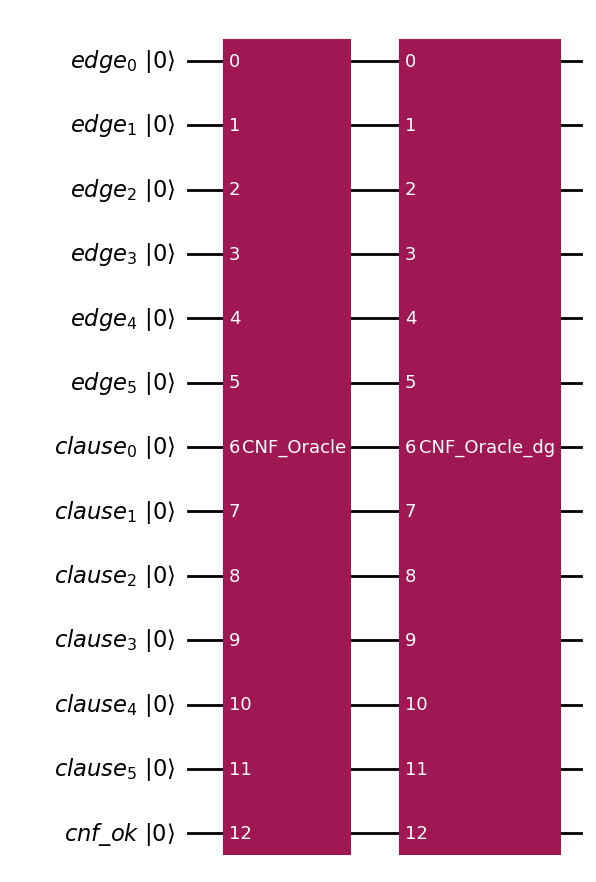

In [8]:
main_qc.draw(output='mpl', initial_state=True, fold=100)

Plotting 64 states for first 6 qubits


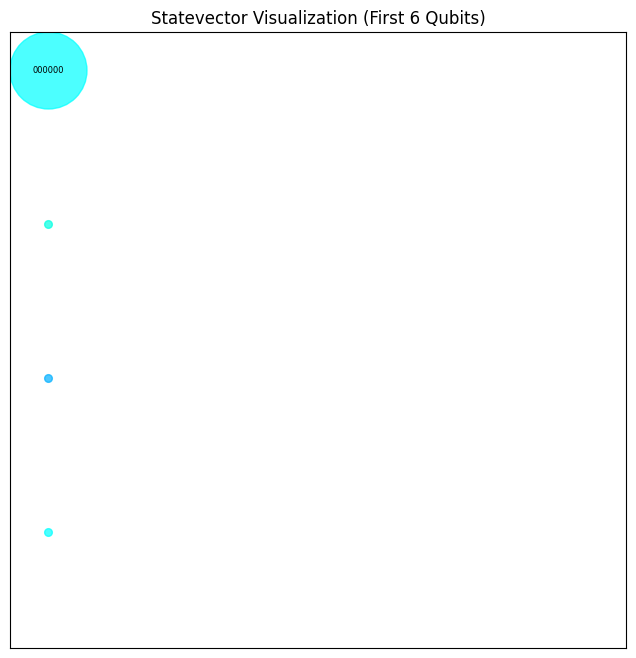

In [9]:
statevector = Statevector(main_qc)
# plot statevector with only the first 6 qubits
plot_statevector_circles(statevector, plot_qubits=6)

In [1]:
def reverse_lines(text):
    """
    Takes a text divided into lines and returns the lines in reversed order.
    
    Args:
        text (str): Input text with multiple lines
        
    Returns:
        str: Text with lines in reversed order
    """
    lines = text.split('\n')
    reversed_lines = lines[::-1]
    return '\n'.join(reversed_lines)

In [3]:
reversed = reverse_lines(
    """
    qc.cx(2, 9)
    qc.cx(0, 10)
    qc.cx(1, 11)
    
    qc.x(6)
    qc.x(7)
    qc.x(8)
    
    qc.cx(4, 9)
    qc.cx(5, 10)
    qc.cx(3, 11)
    
    qc.x(9)
    qc.x(10)
    qc.x(11)
    
    qc.cx(6, 12)
    qc.cx(7, 13)
    qc.cx(8, 14)
    
    qc.x(6)
    qc.x(7)
    qc.x(8)
    
    # reset to |0> qubit 6, 7, 8
    qc.reset(6)
    qc.reset(7)
    qc.reset(8)
    
    qc.mcx([6, 12], 15)
    qc.mcx([7, 13], 16)
    qc.mcx([8, 14], 17)
    
    qc.x(6)
    qc.x(7)
    qc.x(8)
    
    qc.reset(11)
    qc.reset(12)
    qc.reset(13)
    qc.reset(14)
    
    qc.cx(15, 6)
    qc.cx(16, 7)
    qc.cx(17, 8)
    
    qc.mcx([0, 6], 18)
    qc.cx(18, 0)
    qc.cx(0, 9)
    qc.reset(18)
    
    qc.mcx([1, 6], 18)
    qc.cx(18, 1)
    qc.cx(1, 10)
    qc.reset(18)
    
    qc.mcx([2, 7], 18)
    qc.cx(18, 2)
    qc.cx(2, 8)
    qc.reset(18)
    
    qc.mcx([3, 7], 18)
    qc.cx(18, 3)
    qc.cx(3, 11)
    qc.reset(18)
    
    qc.mcx([4, 8], 18)
    
    qc.x(11)
    qc.cx(18, 4)
    qc.reset(18)
    qc.cx(4, 9)
    qc.cx(11, 14)
    
    qc.x(9)
    qc.x(11)
    
    qc.mcx([5, 8], 18)
    qc.cx(18, 5)
    
    qc.cx(9, 12)
    qc.reset(18)
    
    qc.mcx([6, 7, 8], 19)
    qc.p(beta, 19)
    
    qc.cx(5, 10)
    qc.x(9)
    qc.x(10)
    qc.cx(10, 13)
    qc.x(10)
    """
)

In [5]:
print(reversed)

    
    qc.x(10)
    qc.cx(10, 13)
    qc.x(10)
    qc.x(9)
    qc.cx(5, 10)
    
    qc.p(beta, 19)
    qc.mcx([6, 7, 8], 19)
    
    qc.reset(18)
    qc.cx(9, 12)
    
    qc.cx(18, 5)
    qc.mcx([5, 8], 18)
    
    qc.x(11)
    qc.x(9)
    
    qc.cx(11, 14)
    qc.cx(4, 9)
    qc.reset(18)
    qc.cx(18, 4)
    qc.x(11)
    
    qc.mcx([4, 8], 18)
    
    qc.reset(18)
    qc.cx(3, 11)
    qc.cx(18, 3)
    qc.mcx([3, 7], 18)
    
    qc.reset(18)
    qc.cx(2, 8)
    qc.cx(18, 2)
    qc.mcx([2, 7], 18)
    
    qc.reset(18)
    qc.cx(1, 10)
    qc.cx(18, 1)
    qc.mcx([1, 6], 18)
    
    qc.reset(18)
    qc.cx(0, 9)
    qc.cx(18, 0)
    qc.mcx([0, 6], 18)
    
    qc.cx(17, 8)
    qc.cx(16, 7)
    qc.cx(15, 6)
    
    qc.reset(14)
    qc.reset(13)
    qc.reset(12)
    qc.reset(11)
    
    qc.x(8)
    qc.x(7)
    qc.x(6)
    
    qc.mcx([8, 14], 17)
    qc.mcx([7, 13], 16)
    qc.mcx([6, 12], 15)
    
    qc.reset(8)
    qc.reset(7)
    qc.reset(6)
    # reset to |0> qubit 6, 7,